In [1]:
# default_exp cb_geom

This contains calibration board point geometry related stuff. I tried to separate control point and fiducial marker geometries since some calibration boards dont have fiducial markers. I also include boundaries around control points because they can help with control point refinement.

# Import

In [2]:
# export
import matplotlib.pyplot as plt
import numpy as np

from camera_calib_python.utils import *

# Utility

`crrgrid` is centered rectanglular rectangle grid

In [3]:
# export
def crrgrid(num_h, num_w, spacing_h, spacing_w):
    h, w = spacing_h*(num_h-1), spacing_w*(num_w-1)
    return grid2ps(*np.meshgrid(np.linspace(-w/2,  w/2, num_w), np.linspace(-h/2,  h/2, num_h)), 'F')

`csrgrid` is centered square rectangle grid

In [4]:
# export
def csrgrid(num_h, num_w, spacing): return crrgrid(num_h, num_w, spacing, spacing)

`csdgrid` is centered square diamond grid

In [5]:
# export 
def csdgrid(num_h, num_w, spacing, fo): # Pretty sure this implementation can be vastly improved
    h, w = spacing*(num_h-1), spacing*(num_w-1)
    xs_grid, ys_grid = np.linspace(-w/2, w/2, num_w), np.linspace(-h/2, h/2, num_h)
    ps = np.empty((0,2))
    for x_grid in xs_grid:
        if fo:
            ys = ys_grid[0::2]
            fo = False
        else:
            ys = ys_grid[1::2]
            fo = True
        xs = np.tile(x_grid, len(ys))
        ps = np.r_[ps, np.c_[xs, ys]]
    return ps

`cfpgrid` is centered four point grid

In [6]:
# export
def cfpgrid(h, w): return crrgrid(2, 2, h, w)

# Base Classes

`PGeom` is a point geometry

In [7]:
# export
class PGeom():        
    @property
    def ps(self): return NotImplementedError('Please implement ps')

`BGeom` is a boundary geometry

In [8]:
# export
class BGeom():
    @property
    def bs(self): return NotImplementedError('Please implement bs')

# Control Points

In [9]:
# export
class CpGeom(PGeom, BGeom): pass

In [10]:
# export
class CpCSRGrid(CpGeom):
    def __init__(self, num_h, num_w, spacing):
        self.num_h, self.num_w, self.spacing = num_h, num_w, spacing
    
    @property
    def ps(self): return csrgrid(self.num_h, self.num_w, self.spacing)     
    
    @property
    def bs(self):
        b = cfpgrid(self.spacing, self.spacing)[[0,1,3,2]]
        return np.array([b+p for p in self.ps], np.object)

In [11]:
# export
class CpCSDGrid(CpGeom):
    def __init__(self, num_h, num_w, spacing, fo):
        self.num_h, self.num_w, self.spacing, self.fo = num_h, num_w, spacing, fo
    
    @property
    def ps(self): return csdgrid(self.num_h, self.num_w, self.spacing, self.fo)     
    
    @property
    def bs(self):
        b = csdgrid(3, 3, self.spacing, False)[[0,1,3,2]]
        return np.array([b+p for p in self.ps], np.object)

# Fiducial Markers

In [12]:
# export
class FmGeom(PGeom): pass

In [13]:
# export
class FmCFPGrid(FmGeom):
    def __init__(self, h, w):
        self.h, self.w = h, w
    
    @property
    def ps(self): return cfpgrid(self.h, self.w)

# Calibration Board Geometry

It's useful to define a geometry and then later want to remove some points; hence the `idx_c_exclude` and `idx_f_exclude`.

In [14]:
# export
class CbGeom():
    def __init__(
        self, 
        h_cb, 
        w_cb, 
        cp_geom, 
        fm_geom=None, 
        idx_c_exclude=np.empty(0, dtype=np.int), 
        idx_f_exclude=np.empty(0, dtype=np.int)
    ):
        self.h_cb, self.w_cb = h_cb, w_cb
        self.cp_geom = cp_geom
        self.fm_geom = fm_geom
        self.idx_c_exclude = idx_c_exclude
        self.idx_f_exclude = idx_f_exclude
    
    @property
    def ps_c(self): return np.delete(self.cp_geom.ps, self.idx_c_exclude, axis=0)
    
    @property
    def bs_c(self): return np.delete(self.cp_geom.bs, self.idx_c_exclude, axis=0)
        
    @property
    def ps_f(self): return np.delete(self.fm_geom.ps, self.idx_f_exclude, axis=0)
    
    def plt(self, ax=None):
        if ax is None:
            plt.figure(figsize=(10,10))
            ax = plt.gca()

        def _plt_ps(ps, style):
            ax.plot(ps[:,0], ps[:,1], style)
            for idx, p in enumerate(ps): ax.text(p[0], p[1], str(idx))
            
        # Control points
        _plt_ps(self.ps_c, 'gs')
        for b_c in self.bs_c:
            ax.plot(np.r_[b_c[:,0], b_c[0,0]],
                    np.r_[b_c[:,1], b_c[0,1]], 'r')
    
        # Fiducial markers
        if self.fm_geom is not None: _plt_ps(self.ps_f, 'bs')
            
        ax.set_xlim(-self.w_cb/2, self.w_cb/2)
        ax.set_ylim(-self.h_cb/2, self.h_cb/2)
        ax.invert_yaxis()
        ax.set_aspect(1)

# Test

In [15]:
h_cb = 50.8
w_cb = 50.8
h_f = 42.672
w_f = 42.672
num_c_h = 16
num_c_w = 16
spacing_c = 2.032

In [16]:
cb_geom = CbGeom(h_cb, w_cb,
                 CpCSRGrid(num_c_h, num_c_w, spacing_c),
                 FmCFPGrid(h_f, w_f))

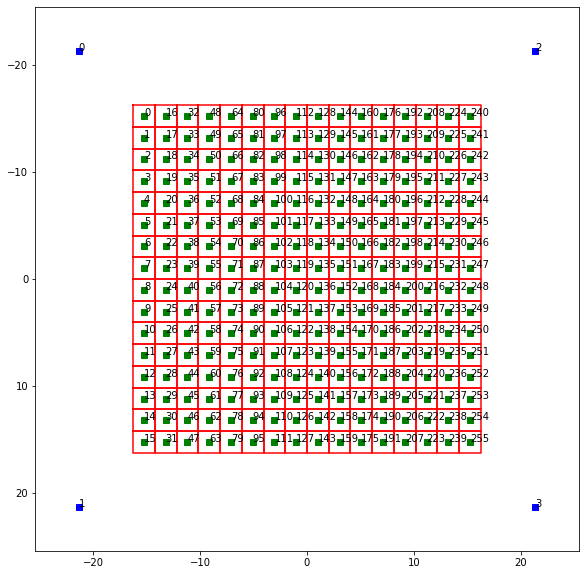

In [17]:
cb_geom.plt()

In [18]:
h_cb = 1500
w_cb = 1500
h_f = 700
w_f = 700
num_c_h = 55
num_c_w = 55
spacing_c = 25
fo = True
idx_c_exclude = np.array([
   0,    1,   28,   55,  281,  282,  308,  309,  310,  335,  336,
 337,  338,  363,  364,  365,  390,  391,  392,  393,  418,  419,
 420,  446,  447,   26,   27,   54,   82,  295,  296,  322,  323,
 324,  349,  350,  351,  352,  377,  378,  379,  404,  405,  406,
 407,  432,  433,  434,  460,  461, 1430, 1458, 1485, 1486, 1051,
1052, 1078, 1079, 1080, 1105, 1106, 1107, 1108, 1133, 1134, 1135,
1160, 1161, 1162, 1163, 1188, 1189, 1190, 1216, 1217, 1457, 1484,
1511, 1512, 1065, 1066, 1092, 1093, 1094, 1119, 1120, 1121, 1122,
1147, 1148, 1149, 1174, 1175, 1176, 1177, 1202, 1203, 1204, 1230,
1231
])

In [19]:
cb_geom = CbGeom(h_cb, w_cb,
                 CpCSDGrid(num_c_h, num_c_w, spacing_c, fo),
                 FmCFPGrid(h_f, w_f),
                 idx_c_exclude)

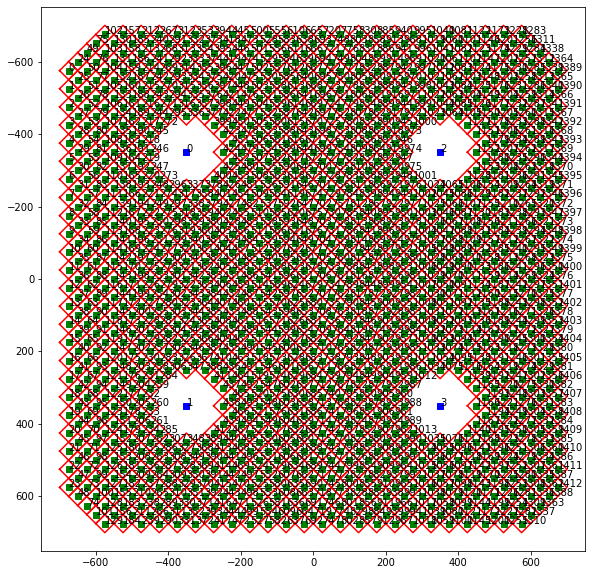

In [20]:
cb_geom.plt()

In [21]:
!nbdev_build_lib

Converted calib.ipynb.
Converted cb_geom.ipynb.
Converted control_refine.ipynb.
Converted coordinate_graph.ipynb.
Converted fiducial_detect.ipynb.
Converted image.ipynb.
Converted modules.ipynb.
Converted test.ipynb.
Converted utils.ipynb.
